In [1]:
from pylab import plt
plt.style.use('seaborn')
%matplotlib inline

#### Chapter 11: Calibration

* Why do we need to calibrate?
    * Given Derivative asset cannot be replicated completely by trading in underlying
    * Due to continuous processes and jumps
    * Some models are incomplete due to continuous process limitations
    * Some models are incomplete due to non-consideration of jump processes
* Since jump size is not known in advance, risks associated with jumps cannot be hedged 
* So instead of trying to replicate an option, your task is to minimize hedging error
* Market incompleteness leads to a scenario where we get multiple prices for derivatives of assets
* Since we do not have any simple criterion to choose among the risk measures, we use the market to calibrate
* Calibration yields market-consistent, risk-neutral probability measure
    * liquid vanilla options are accurately priced
    * exotic derivatives are prices with absence of arbitrage constraint as well as being unique
* Calibration, in practice, is finding parameters for a given model such that it is market-consistent


#### Model comparison

* M76 (Merton 76) is not capable of perfectly replicating prices for multiple strikes and maturities
    * For short maturities and a subset of option prices it works pretty good
* BCC97 includes a jump component which can handle short-term pricing
* H93 is good at replicating prices with longer maturities
* When calibrating an asset to short and long term maturities one needs stochastic volatility and jump components
* B96 can accomodate both stochastica volatility and jumps
    * B96 is based on two sub models H93 and M76
* Short rate volatility effect is small for short maturity option prices
* For longer maturity options, short rate volatility must be considered 
* Stochastic short rates are used for:
    * risk-neutral valuation and hedging in general
    * central for computing deterministic cash-flows
* Short rate model is calibrated to replicate term structure of interest rates and short-rate sensitive instruments are priced reasonably well
* Since there is zero correlation between short rate and index model, the general model calibration can be broken into two procedures

#### Calibration to an objective function
* Some benchmark is required to measure the goodness of calibration
* Objective/Cost functions that need to be minimized perform this role
* Model selection and objective function are two seperate procedures
* Objective functions to consider could be: 
    * MSE of price difference in currency units
    * MSE of relative price differences 
    * MSE of implied volatility differences
* When performing error minimization you must consider there may be multiple local minima 
* It can be hard to determine that you have found the global minima in such a scenario
* Calibrated to implied volatility
    * Take the difference between model and market implied vol
    * Takes into account how sensitive vanilla options are wrt changes in volatility for different strikes/maturities
    * Vega increases with closeness to ATM for longer maturities
    * Such an error function would give less weight to implied vol ITM, OTM shorter term options 

#### Calibration to Euribor rates
* Forward rates are not quoted but yields, reference or swap rates
    * Treasury
    * Bunds
    * Libor
    * Euribor
    * EONIA 
* ZCB and forward rates are directly correlated one-to-one
* Spot rates and bond yields are quoted for discrete maturities
* Need to interpolate between single data points
* Using cublic spline regression you can get partial derivative and forward rates for arbitrary time T

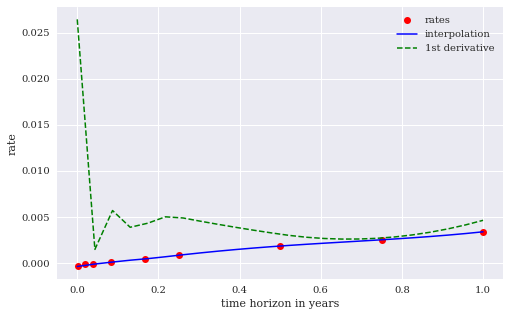

In [4]:
plot_term_structure()

In [16]:
opt = CIR_calibration()


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 270
         Function evaluations: 485


In [17]:
opt

array([0.146849, 0.104511, 0.175197])

#### Plotting the market vs modeled rates and the differences between them
* Model implied forward rates

In [14]:
CIR_forward_rate(opt)

array([-0.000320, 0.000015, 0.000347, 0.000677, 0.001006, 0.001332,
       0.001656, 0.001977, 0.002297, 0.002614, 0.002930, 0.003243,
       0.003554, 0.003863, 0.004169, 0.004474, 0.004776, 0.005076,
       0.005374, 0.005670, 0.005963, 0.006254, 0.006544, 0.006831])

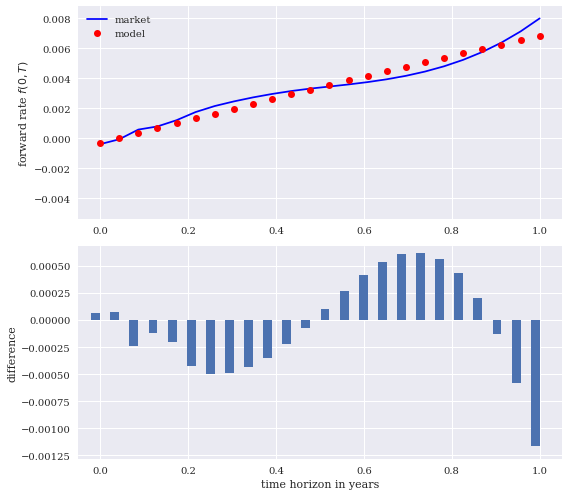

In [15]:
plot_calibrated_frc(opt)

##### Calibration adjusted values for unit-zero coupon bond maturing 2 years out according to bond valuation formula

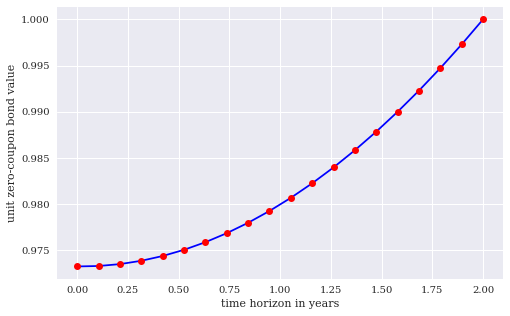

In [18]:
plot_zcb_values(opt, 2.0)

#### Equity component calibration
* BCC97 Market model to market observed option quotes
* Once we can calibrate our short rate model we can use the short rates to valuation of plain vanilla call options
* This allows us to model the equity component in the general market model
* The characteristic function BCC97 with constant short rate is the product of hte H93 characteristic function and M76 characteristic functino


#### Calibrating EuroStoxx 50 Option quotes

* 3 maturities and 5 strike prices

In [21]:
#
# Calibration of CIR85 model
# to Euribor Rates from 30. September 2014
# 11_cal/CIR_calibration.py
#
# (c) Dr. Yves J. Hilpisch
# Derivatives Analytics with Python
#
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.interpolate as sci
from scipy.optimize import fmin
sys.path.append('10_mcs')
from CIR_zcb_valuation_gen import B

mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(suppress=True,
                    formatter={'all': lambda x: '%7.6f' % x})

#
# Market Data: Eonia rate (01.10.2014) + Euribor rates
# Source: http://www.emmi-benchmarks.eu
# on 30. September 2014
#
t_list = np.array((1, 7, 14, 30, 60, 90, 180, 270, 360)) / 360.
r_list = np.array((-0.032, -0.013, -0.013, 0.007, 0.043,
                   0.083, 0.183, 0.251, 0.338)) / 100

factors = (1 + t_list * r_list)
zero_rates = 1 / t_list * np.log(factors)

r0 = r_list[0]  # 0.0  # set to zero

#
# Interpolation of Market Data
#

tck = sci.splrep(t_list, zero_rates, k=3)  # cubic splines
tn_list = np.linspace(0.0, 1.0, 24)
ts_list = sci.splev(tn_list, tck, der=0)
de_list = sci.splev(tn_list, tck, der=1)

f = ts_list + de_list * tn_list
# forward rate transformation


def plot_term_structure():
    plt.figure(figsize=(8, 5))
    plt.plot(t_list, r_list, 'ro', label='rates')
    # cubic splines
    plt.plot(tn_list, ts_list, 'b', label='interpolation', lw=1.5)
    # first derivative
    plt.plot(tn_list, de_list, 'g--', label='1st derivative', lw=1.5)
    plt.legend(loc=0)
    plt.xlabel('time horizon in years')
    plt.ylabel('rate')


#
# Model Forward Rates
#
def CIR_forward_rate(opt):
    ''' Function for forward rates in CIR85 model.

    Parameters
    ==========
    kappa_r: float
        mean-reversion factor
    theta_r: float
        long-run mean
    sigma_r: float
        volatility factor

    Returns
    =======
    forward_rate: float
        forward rate
    '''
    kappa_r, theta_r, sigma_r = opt
    t = tn_list
    g = np.sqrt(kappa_r ** 2 + 2 * sigma_r ** 2)
    sum1 = ((kappa_r * theta_r * (np.exp(g * t) - 1)) /
            (2 * g + (kappa_r + g) * (np.exp(g * t) - 1)))
    sum2 = r0 * ((4 * g ** 2 * np.exp(g * t)) /
                 (2 * g + (kappa_r + g) * (np.exp(g * t) - 1)) ** 2)
    forward_rate = sum1 + sum2
    return forward_rate

#
# Error Function
#


def CIR_error_function(opt):
    ''' Error function for CIR85 model calibration. '''
    kappa_r, theta_r, sigma_r = opt
    if 2 * kappa_r * theta_r < sigma_r ** 2:
        return 100
    if kappa_r < 0 or theta_r < 0 or sigma_r < 0.001:
        return 100
    forward_rates = CIR_forward_rate(opt)
    MSE = np.sum((f - forward_rates) ** 2) / len(f)
    # print opt, MSE
    return MSE

#
# Calibration Procedure
#


def CIR_calibration():
    opt = fmin(CIR_error_function, [1.0, 0.02, 0.1],
               xtol=0.00001, ftol=0.00001,
               maxiter=300, maxfun=500)
    return opt

#
# Graphical Results Output
#


def plot_calibrated_frc(opt):
    ''' Plots market and calibrated forward rate curves. '''
    forward_rates = CIR_forward_rate(opt)
    plt.figure(figsize=(8, 7))
    plt.subplot(211)
    plt.ylabel('forward rate $f(0,T)$')
    plt.plot(tn_list, f, 'b', label='market')
    plt.plot(tn_list, forward_rates, 'ro', label='model')
    plt.legend(loc=0)
    plt.axis([min(tn_list) - 0.05, max(tn_list) + 0.05,
              min(f) - 0.005, max(f) * 1.1])
    plt.subplot(212)
    wi = 0.02
    plt.bar(tn_list - wi / 2, forward_rates - f, width=wi)
    plt.xlabel('time horizon in years')
    plt.ylabel('difference')
    plt.axis([min(tn_list) - 0.05, max(tn_list) + 0.05,
              min(forward_rates - f) * 1.1, max(forward_rates - f) * 1.1])
    plt.tight_layout()


def plot_zcb_values(p0, T):
    ''' Plots unit zero-coupon bond values (discount factors). '''
    t_list = np.linspace(0.0, T, 20)
    r_list = B([r0, p0[0], p0[1], p0[2], t_list, T])
    plt.figure(figsize=(8, 5))
    plt.plot(t_list, r_list, 'b')
    plt.plot(t_list, r_list, 'ro')
    plt.xlabel('time horizon in years')
    plt.ylabel('unit zero-coupon bond value')


In [25]:
#
# Calibration of Bakshi, Cao and Chen (1997)
# Stoch Vol Jump Model to EURO STOXX Option Quotes
# Data Source: www.eurexchange.com
# via Numerical Integration
# 11_cal/BCC97_calibration_2.py
#
# (c) Dr. Yves J. Hilpisch
# Derivatives Analytics with Python
#
import sys
import math
import numpy as np
import pandas as pd
import matplotlib as mpl
from scipy.optimize import brute, fmin

sys.path.append('09_gmm')
from BCC_option_valuation import H93_call_value
# from CIR_calibration import CIR_calibration, r_list
# from CIR_zcb_valuation import B

mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(suppress=True,
                    formatter={'all': lambda x: '%5.3f' % x})
#
# Calibrate Short Rate Model
#
kappa_r, theta_r, sigma_r = CIR_calibration()

#
# Market Data from www.eurexchange.com
# as of 30. September 2014
#
h5 = pd.HDFStore('08_m76/option_data.h5', 'r')
data = h5['data']  # European call & put option data (3 maturities)
h5.close()
S0 = 3225.93  # EURO STOXX 50 level 30.09.2014
r0 = r_list[0]  # initial short rate (Eonia 30.09.2014)

#
# Option Selection
#
tol = 0.02  # percent ITM/OTM options
options = data[(np.abs(data['Strike'] - S0) / S0) < tol]
options['Date'] = pd.DatetimeIndex(options['Date'])
options['Maturity'] = pd.DatetimeIndex(options['Maturity'])

# options = data[data['Strike'].isin([3100, 3150, 3225, 3300, 3350])]

#
# Adding Time-to-Maturity and Short Rates
#
for row, option in options.iterrows():
    T = (option['Maturity'] - option['Date']).days / 365.
    options.loc[row, 'T'] = T
    B0T = B([kappa_r, theta_r, sigma_r, r0, T])
    options.loc[row, 'r'] = -math.log(B0T) / T

#
# Calibration Functions
#
i = 0
min_MSE = 500


def H93_error_function(p0):
    ''' Error function for parameter calibration in BCC97 model via
    Lewis (2001) Fourier approach.

    Parameters
    ==========
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial, instantaneous variance

    Returns
    =======
    MSE: float
        mean squared error
    '''
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or \
            rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v ** 2:
        return 500.0
    se = []
    for row, option in options.iterrows():
        model_value = H93_call_value(S0, option['Strike'], option['T'],
                                     option['r'], kappa_v, theta_v, sigma_v,
                                     rho, v0)
        se.append((model_value - option['Call']) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print('%4d |' % i, np.array(p0), '| %7.3f | %7.3f' % (MSE, min_MSE))
    i += 1
    return MSE


def H93_calibration_full():
    ''' Calibrates H93 stochastic volatility model to market quotes. '''
    # first run with brute force
    # (scan sensible regions)
    p0 = brute(H93_error_function,
               ((2.5, 10.6, 5.0),  # kappa_v
                (0.01, 0.041, 0.01),  # theta_v
                (0.05, 0.251, 0.1),  # sigma_v
                (-0.75, 0.01, 0.25),  # rho
                (0.01, 0.031, 0.01)),  # v0
               finish=None)

    # second run with local, convex minimization
    # (dig deeper where promising)
    opt = fmin(H93_error_function, p0,
               xtol=0.000001, ftol=0.000001,
               maxiter=750, maxfun=900)
    np.save('11_cal/opt_sv', np.array(opt))
    return opt


def H93_calculate_model_values(p0):
    ''' Calculates all model values given parameter vector p0. '''
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    values = []
    for row, option in options.iterrows():
        model_value = H93_call_value(S0, option['Strike'], option['T'],
                                     option['r'], kappa_v, theta_v, sigma_v,
                                     rho, v0)
        values.append(model_value)
    return np.array(values)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 270
         Function evaluations: 485


In [26]:
options

,Date,Strike,Call,Maturity,Put,T,r
38,2014-09-30,3175.0,126.8,2014-12-19,78.8,0.219178,0.001349
39,2014-09-30,3200.0,110.9,2014-12-19,87.9,0.219178,0.001349
40,2014-09-30,3225.0,96.1,2014-12-19,98.1,0.219178,0.001349
41,2014-09-30,3250.0,82.3,2014-12-19,109.3,0.219178,0.001349
42,2014-09-30,3275.0,69.6,2014-12-19,121.6,0.219178,0.001349
342,2014-09-30,3175.0,171.0,2015-03-20,129.2,0.468493,0.003203
343,2014-09-30,3200.0,156.1,2015-03-20,139.4,0.468493,0.003203
344,2014-09-30,3225.0,142.0,2015-03-20,150.3,0.468493,0.003203
345,2014-09-30,3250.0,128.5,2015-03-20,161.8,0.468493,0.003203
346,2014-09-30,3275.0,115.8,2015-03-20,174.0,0.468493,0.003203


In [27]:
opt_sv = H93_calibration_full()

   0 | [2.500 0.010 0.050 -0.750 0.010] | 1383.261 | 500.000
  25 | [2.500 0.020 0.050 -0.750 0.010] | 776.135 |  37.017
  50 | [2.500 0.020 0.250 -0.750 0.020] | 189.987 |  11.029
  75 | [2.500 0.030 0.150 -0.750 0.030] |  73.318 |   7.465
 100 | [2.500 0.040 0.050 -0.500 0.010] | 215.473 |   7.465
 125 | [2.500 0.040 0.250 -0.500 0.020] |  34.849 |   7.465
 150 | [7.500 0.010 0.150 -0.500 0.030] | 344.185 |   7.465
 175 | [7.500 0.020 0.050 -0.250 0.010] | 433.526 |   7.465
 200 | [7.500 0.020 0.250 -0.250 0.020] | 151.386 |   7.465
 225 | [7.500 0.030 0.150 -0.250 0.030] |  87.733 |   7.465
 250 | [7.500 0.040 0.050 0.000 0.010] | 171.852 |   7.465
 275 | [7.500 0.040 0.250 0.000 0.020] | 227.431 |   7.465
 300 | [2.078 0.023 0.220 -0.871 0.028] |   5.897 |   5.683
 325 | [1.777 0.024 0.223 -0.900 0.028] |   5.539 |   5.358
 350 | [1.518 0.023 0.243 -0.968 0.028] |   5.167 |   5.147
 375 | [2.027 0.024 0.237 -0.992 0.028] |   5.043 |   4.997
 400 | [2.820 0.024 0.236 -0.998 0.028] |

In [28]:
options['Model'] = H93_calculate_model_values(opt_sv)

In [29]:
np.sum(options['Model'] - options['Call'])

0.074370708113228545

In [30]:
np.sum(abs(options['Model'] - options['Call']))

6.4923097895529267

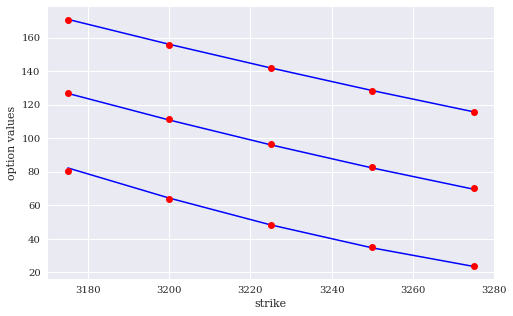

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for mat in set(options['Maturity']):
    options[options.Maturity == mat].plot(x='Strike', y='Call',
                                          style='b', lw=1.5,
                                          legend=False, ax=ax)
    options[options.Maturity == mat].plot(x='Strike', y='Model',
                                          style='ro', legend=False,
                                          ax=ax)
plt.xlabel('strike')
plt.ylabel('option values')
plt.grid(True)

In [32]:
options['Model'] = H93_calculate_model_values(opt_sv)

In [35]:
#
# Black-Scholes-Merton Implied Volatilities of
# of Calibrated BCC97 Model
# Data Source: www.eurexchange.com, 30. September 2014
# 11_cal/plot_implied_volatilities.py
#
# (c) Dr. Yves J. Hilpisch
# Derivatives Analytics with Python
#
import sys
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt



sys.path.extend(['03_stf', '09_gmm'])
from BSM_imp_vol import call_option
from CIR_zcb_valuation import B

mpl.rcParams['font.family'] = 'serif'

#
# Calibration Results
#


def calculate_implied_volatilities(filename):
    ''' Calculates market and model implied volatilities. '''
    h5 = pd.HDFStore(filename, 'r')
    options = h5['options']
    h5.close()
    for row, option in options.iterrows():
        # T = (option['Maturity'] - option['Date']).days / 365.
        # B0T = B([kappa_r, theta_r, sigma_r, r0, T])
        # r = -math.log(B0T) / T
        call = call_option(S0, option['Strike'], option['Date'],
                           option['Maturity'], option['r'], 0.1)
        options.loc[row, 'market_iv'] = call.imp_vol(option['Call'], 0.15)
        options.loc[row, 'model_iv'] = call.imp_vol(option['Model'], 0.15)
    return options


def plot_implied_volatilities(options, model):
    ''' Plots market implied volatilities against model implied ones. '''
    global opts
    mats = sorted(set(options.Maturity))
    for mat in mats:
        opts = options[options.Maturity == mat]
        plt.figure(figsize=(8, 6))
        plt.subplot(211)
        plt.ylabel('implied volatility')
        plt.plot(opts.Strike, opts.market_iv, 'b', label='market', lw=1.5)
        plt.plot(opts.Strike, opts.model_iv, 'ro', label='model')
        plt.legend(loc=0)
        plt.axis([min(opts.Strike) - 10, max(opts.Strike) + 10,
                  min(opts.market_iv) - 0.015, max(opts.market_iv) + 0.015])
        plt.title('Maturity %s' % str(mat)[:10])
        plt.subplot(212)
        wi = 5.0
        diffs = opts.model_iv.values - opts.market_iv.values
        plt.bar(opts.Strike.values - wi / 2, diffs, width=wi)
        plt.ylabel('difference')
        ymi = min(diffs) - (max(diffs) - min(diffs)) * 0.1
        yma = max(diffs) + (max(diffs) - min(diffs)) * 0.1
        plt.axis([min(opts.Strike) - 10, max(opts.Strike) + 10, ymi, yma])
        plt.tight_layout()
        plt.savefig('../images/11_cal/%s_calibration_iv_%s.pdf'
                    % (model, str(mat)[:10]))


In [37]:
filename = '11_cal/cal_results_sv.h5'

options = calculate_implied_volatilities(filename)

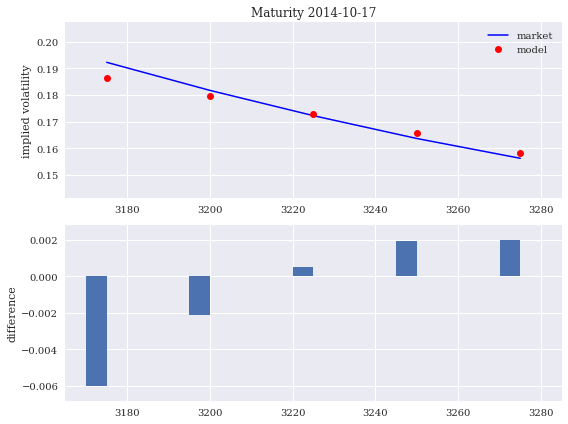

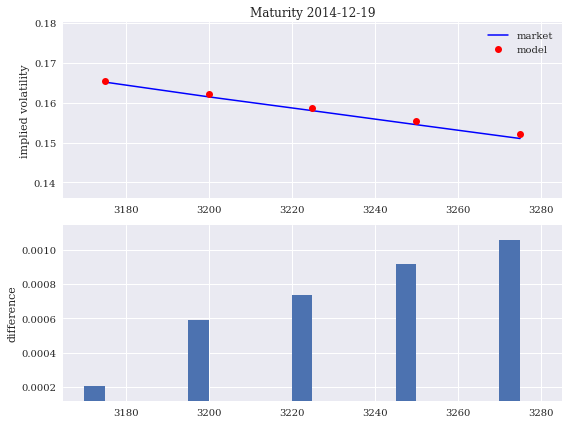

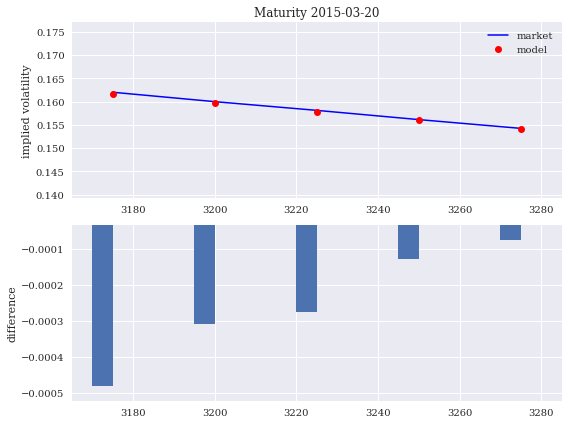

In [38]:
plot_implied_volatilities(options, 'H93')

In [41]:
#
# Calibration of Bakshi, Cao and Chen (1997)
# Stoch Vol Jump Model to EURO STOXX Option Quotes
# Data Source: www.eurexchange.com
# via Numerical Integration
# 11_cal/BCC97_calibration_short.py
#
# (c) Dr. Yves J. Hilpisch
# Derivatives Analytics with Python
#
import sys
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import brute, fmin

sys.path.append('09_gmm')
from BCC_option_valuation import BCC_call_value
# from CIR_calibration import CIR_calibration, r_list
from CIR_zcb_valuation import B
# from H93_calibration import options

mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(suppress=True,
                    formatter={'all': lambda x: '%5.3f' % x})
#
# Calibrate Short Rate Model
#
kappa_r, theta_r, sigma_r = CIR_calibration()

#
# Market Data from www.eurexchange.com
# as of 30. September 2014
#
S0 = 3225.93  # EURO STOXX 50 level
r0 = r_list[0]  # initial short rate (Eonia 30.09.2014)
#
# Option Selection
#
mats = sorted(set(options['Maturity']))
# only shortest maturity
options = options[options['Maturity'] == mats[0]]

#
# Initial Parameter Guesses
#
# from H93 model calibration
kappa_v, theta_v, sigma_v, rho, v0 = np.load('11_cal/opt_sv.npy')


#
# Calibration Functions
#
i = 0
min_MSE = 5000.0
local_opt = False


def BCC_error_function(p0):
    ''' Error function for parameter calibration in M76 Model via
    Carr-Madan (1999) FFT approach.

    Parameters
    ==========
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump

    Returns
    =======
    MSE: float
        mean squared error
    '''
    global i, min_MSE, local_opt, opt1
    lamb, mu, delta = p0
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    se = []
    for row, option in options.iterrows():
        model_value = BCC_call_value(S0, option['Strike'], option['T'],
                                     option['r'], kappa_v, theta_v, sigma_v,
                                     rho, v0, lamb, mu, delta)
        se.append((model_value - option['Call']) ** 2)
    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print('%4d |' % i, np.array(p0), '| %7.3f | %7.3f' % (MSE, min_MSE))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return MSE + penalty
    return MSE

#
# Calibration
#


def BCC_calibration_short():
    ''' Calibrates jump component of BCC97 model to market quotes. '''
    # first run with brute force
    # (scan sensible regions)
    opt1 = 0.0
    opt1 = brute(BCC_error_function,
                 ((0.0, 0.51, 0.1),  # lambda
                  (-0.5, -0.11, 0.1),  # mu
                  (0.0, 0.51, 0.25)),  # delta
                 finish=None)

    # second run with local, convex minimization
    # (dig deeper where promising)
    opt2 = fmin(BCC_error_function, opt1,
                xtol=0.0000001, ftol=0.0000001,
                maxiter=550, maxfun=750)
    np.save('11_cal/opt_jump', np.array(opt2))
    return opt2


def BCC_jump_calculate_model_values(p0):
    ''' Calculates all model values given parameter vector p0. '''
    lamb, mu, delta = p0
    values = []
    for row, option in options.iterrows():
        T = (option['Maturity'] - option['Date']).days / 365.
        B0T = B([kappa_r, theta_r, sigma_r, r0, T])
        r = -math.log(B0T) / T
        model_value = BCC_call_value(S0, option['Strike'], T, r,
                                     kappa_v, theta_v, sigma_v, rho, v0,
                                     lamb, mu, delta)
        values.append(model_value)
    return np.array(values)

#
# Graphical Results Output
#


def plot_calibration_results(p0):
    options['Model'] = BCC_jump_calculate_model_values(p0)
    plt.figure(figsize=(8, 6))
    plt.subplot(211)
    plt.title('Maturity %s' % str(options['Maturity'].iloc[0])[:10])
    plt.ylabel('option values')
    plt.plot(options.Strike, options.Call, 'b', label='market')
    plt.plot(options.Strike, options.Model, 'ro', label='model')
    plt.legend(loc=0)
    plt.axis([min(options.Strike) - 10, max(options.Strike) + 10,
              min(options.Call) - 10, max(options.Call) + 10])
    plt.subplot(212)
    wi = 5.0
    diffs = options.Model.values - options.Call.values
    plt.bar(options.Strike.values - wi / 2, diffs, width=wi)
    plt.ylabel('difference')
    plt.axis([min(options.Strike) - 10, max(options.Strike) + 10,
              min(diffs) * 1.1, max(diffs) * 1.1])
    plt.tight_layout()


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 270
         Function evaluations: 485


In [42]:
 opt_jump = BCC_calibration_short()

   0 | [0.000 -0.500 0.000] |   0.651 |   0.651
  25 | [0.200 -0.500 0.000] |  40.649 |   0.651
  50 | [0.400 -0.500 0.250] | 160.988 |   0.651
  75 | [0.000 -0.525 0.000] |   0.651 |   0.646
 100 | [0.011 -0.236 0.001] |   0.580 |   0.577
 125 | [0.009 -0.532 0.000] |   0.558 |   0.558
 150 | [0.008 -0.599 0.000] |   0.558 |   0.558
 175 | [0.008 -0.600 0.001] |   0.558 |   0.558
 200 | [0.008 -0.600 0.001] |   0.558 |   0.558
Optimization terminated successfully.
         Current function value: 0.557747
         Iterations: 118
         Function evaluations: 220


In [43]:
options['Model'] = BCC_jump_calculate_model_values(opt_jump)

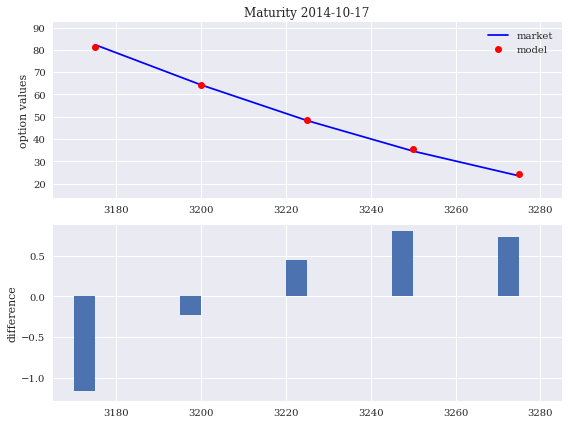

In [44]:
plot_calibration_results(opt_jump)

#### Calibrate the stochastic vol and the jump component
* jump component has two issues with it
    * Degeneracy: different param combos may yield the same values for error function
    * Indeterminancy: there may be more than one solution due to non-convexity
* if you recalibrate models, these parameters may shift and you want to penalize that


#### Full Calibration of BCC97
* We have some representation of how to price derivatives
* It's inputs themselves are based on models of short rates, jump processes and stochastic volatility
* Those model subcomponents need to be calibrated against market data 
* We perform an optimization step to find the parameters that minimize the difference between observed and modeled
* We take the calibrated short-rate model and use it to value vanilla European call options
* We calibrate our vanilla pricing model with actual prices and our calibrated interest rate model
* H93 stochastic vol calibration and jump component calibration are used as inputs into local optimization
* Perform simultaneous optmization for all params
* Calibration to prices or implied vol
* If calibrating for implied vol:
    * first calculate market implied volatilities
    * model implied volatility per iteration of local optimization run
    * Use of different error function: vega-weighted MSE

* Take market interest rates and market prices for vanilla call options
    * Using local and global optimization: Find the parameters that replicate observed quotes
    * Selecting the data to use to calibrate these modles is important 
    * Selecting the error function to minimize is also important and depends on the task